In [1]:
import os
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import GridSearchCV

from Dataset_Construction import Balance_Ratio 
from Sampling import label_divide
from AdaClassifier import train_set, multiple_set, print_badC, bad_plot, line_chart, cf_matrix
from AdaRegressor import AUC, PR_curve, multiple_curve, PR_matrix, best_threshold 
from Aging_Score import score1

os.chdir('C:/Users/Darui Yen/OneDrive/桌面/data_after_mid') 
os.getcwd()

'C:\\Users\\Darui Yen\\OneDrive\\桌面\\data_after_mid'

### Boosting model

In [2]:
def XGBoostC(train_x, test_x, train_y, test_y, n_estimator = 50):
    
    clf = xgb.XGBClassifier(booster = 'gbtree', n_estimators = n_estimator, learning_rate = 0.1, min_child_weight = 4, 
                            subsample = 0.7, max_depth = 9, reg_lambda = 0.2)
    clf.fit(train_x, train_y)
    predict_y = clf.predict(test_x)
    result = pd.DataFrame({'truth': test_y, 'predict': predict_y})
    
    return result
    
    
def XGBoostR(train_x, test_x, train_y, test_y, n_estimator = 200):
    
    reg = xgb.XGBRegressor(booster = 'gbtree', n_estimators = n_estimator, learning_rate = 0.1, min_child_weight = 4, 
                           subsample = 0.7, max_depth = 7, reg_lambda = 0.2)
    reg.fit(train_x, train_y)
    predict_y = reg.predict(test_x)
    result = pd.DataFrame({'truth': test_y, 'predict': predict_y})

    return result

### Run all dataset

In [3]:
def runall_XGBoostC(num_set, trainset_x, test_x, trainset_y, test_y, record_bad = True):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()

    for i in range(num_set):
        print('\n', f'Dataset {i}:')
        
        result = XGBoostC(trainset_x[f'set{i}'], test_x, trainset_y[f'set{i}'], test_y)
        table = cf_matrix(result, trainset_y[f'set{i}'])
        table_set = pd.concat([table_set, table]).rename(index = {0: f'dataset {i}'})
        
        if record_bad:
            bad_table = print_badC(result, test_x, Bad_Types) 
            bad_set = pd.concat([bad_set, bad_table]).rename(index = {0: f'dataset {i}'})

    if record_bad:
        return table_set, bad_set
    else:
        return table_set
    
    
def runall_XGBoostR(num_set, trainset_x, test_x, trainset_y, test_y, thres_target = 'Recall', threshold = 0.8, 
                          record_bad = True):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    pr_dict = {}

    for i in range(num_set):
        print('\n', f'Dataset {i}:')

        predict = XGBoostR(trainset_x[f'set{i}'], test_x, trainset_y[f'set{i}'], test_y)
        pr_matrix = PR_matrix(predict, trainset_y[f'set{i}'])
        pr_dict[f'set{i}'] = pr_matrix
        
        best_data, best_thres = best_threshold(pr_matrix, target = thres_target, threshold = threshold)
        table_set = pd.concat([table_set, best_data]).rename(index = {best_data.index.values[0]: f'dataset {i}'})
        
        if record_bad:
            bad_table = print_badC(predict, test_x, Bad_Types, threshold = best_thres)
            bad_set = pd.concat([bad_set, bad_table]).rename(index = {0: f'dataset {i}'})
    
    if record_bad:
        return pr_dict, table_set, bad_set
    else:
        return pr_dict, table_set

## Data Processing

In [4]:
###bad types###
bad = pd.read_csv('original_data/Bad_Types.csv').iloc[:, 1:]
Bad_Types = {bad.cb[i]:i for i in range (len(bad))}
print('Total bad types:', len(bad))

###single dataset###
test = pd.read_csv('original_data/TestingSet_0.csv').iloc[:, 2:]
train = pd.read_csv('original_data/TrainingSet_new.csv').iloc[:, 2:]
print('\ntraining data:', train.shape, '\nBalance Ratio:', Balance_Ratio(train))
print('\ntesting data:', test.shape, '\nBalance Ratio:', Balance_Ratio(test))

train_x, train_y, test_x, test_y = label_divide(train, test, 'GB')

###multiple dataset###
data_dict = multiple_set(num_set = 9)
trainset_x, trainset_y = train_set(data_dict, num_set = 9, label = 'GB')
test_x, test_y = label_divide(test, None, 'GB', train_only = True)


#####for runhist dataset#####
bad = pd.read_csv('run_bad_types.csv').iloc[:, 1:]
Bad_Types = {bad.cb[i]:i for i in range (len(bad))}
print('Total bad types:', len(bad))

run_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
run_test_x, run_test_y = label_divide(run_test, None, 'GB', train_only = True)

Total bad types: 62

training data: (77138, 83) 
Balance Ratio: 18.17902

testing data: (55903, 83) 
Balance Ratio: 3104.72222
Dimension of dataset 0 : (80395, 690)  balance ratio: 902.31461
Dimension of dataset 1 : (120449, 690)  balance ratio: 2.0005
Dimension of dataset 2 : (120503, 690)  balance ratio: 1.99781
Dimension of dataset 3 : (120503, 690)  balance ratio: 1.99781
Dimension of dataset 4 : (120459, 690)  balance ratio: 2.0
Dimension of dataset 5 : (654, 690)  balance ratio: 2.12919
Dimension of dataset 6 : (712, 690)  balance ratio: 1.66667
Dimension of dataset 7 : (712, 690)  balance ratio: 1.66667
Dimension of dataset 8 : (667, 690)  balance ratio: 2.0045

 9 datasets are loaded.

Labels of  9 datasets are divided.
Total bad types: 67



 Dataset 0:


C:\Users\Darui Yen\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:44:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Darui Yen\OneDrive\jupyter_script\AUO_aging\AdaClassifier.py:106: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\Darui Yen\OneDrive\jupyter_script\AUO_aging\Aging_Score.py:21: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Types of Bad found: []
Types of Bad not found: [35, 36, 37, 38, 39, 40, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]

 Dataset 1:


C:\Users\Darui Yen\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:46:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.00016099314884711018
Types of Bad found: []
Types of Bad not found: [35, 36, 37, 38, 39, 40, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]

 Dataset 2:


C:\Users\Darui Yen\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:47:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Precision: 0.0 
Recall: 0.0 
Aging Rate: 1.788812764967891e-05
Types of Bad found: []
Types of Bad not found: [35, 36, 37, 38, 39, 40, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]

 Dataset 3:


C:\Users\Darui Yen\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:49:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Darui Yen\OneDrive\jupyter_script\AUO_aging\AdaClassifier.py:106: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\Darui Yen\OneDrive\jupyter_script\AUO_aging\Aging_Score.py:21: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Types of Bad found: []
Types of Bad not found: [35, 36, 37, 38, 39, 40, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]

 Dataset 4:


C:\Users\Darui Yen\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:51:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Precision: 0.0 
Recall: 0.0 
Aging Rate: 5.3664382949036725e-05
Types of Bad found: []
Types of Bad not found: [35, 36, 37, 38, 39, 40, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]

 Dataset 5:
[01:53:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Darui Yen\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Precision: 0.00032292208607667607 
Recall: 1.0 
Aging Rate: 0.997102123320752
Types of Bad found: [35, 36, 37, 38, 39, 40, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]
Types of Bad not found: []

 Dataset 6:
[01:53:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Darui Yen\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Precision: 0.000322696306920043 
Recall: 1.0 
Aging Rate: 0.9977997602990895
Types of Bad found: [35, 36, 37, 38, 39, 40, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]
Types of Bad not found: []

 Dataset 7:
[01:53:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Darui Yen\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Precision: 0.00032232070910556004 
Recall: 1.0 
Aging Rate: 0.9989624885963186
Types of Bad found: [35, 36, 37, 38, 39, 40, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]
Types of Bad not found: []

 Dataset 8:
[01:53:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Darui Yen\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Precision: 0.0003227946846475261 
Recall: 1.0 
Aging Rate: 0.997495662129045
Types of Bad found: [35, 36, 37, 38, 39, 40, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]
Types of Bad not found: []


TypeError: tuple indices must be integers or slices, not str

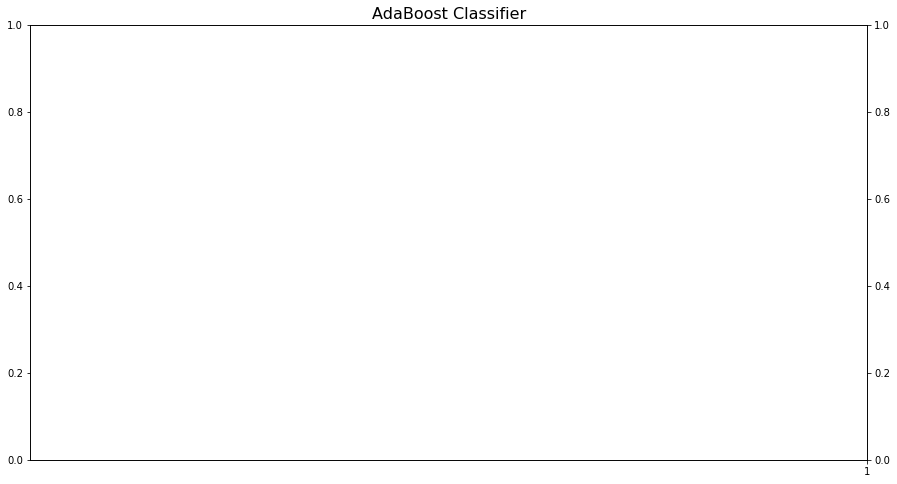

In [5]:
#####for runhist dataset#####
table_set1 = runall_XGBoostC(9, trainset_x, run_test_x, trainset_y, run_test_y, record_bad = False)
line_chart(table_set1)

In [16]:
table_set1[0]

,Balance Ratio,Train_OK,Train_NG,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,Score
dataset 0,902.314607,80306.0,89.0,0.0,0.0,18.0,55885.0,0.000000,0.0,0.000000,NaN,NaN
dataset 1,2.000498,80306.0,40143.0,0.0,9.0,18.0,55876.0,0.000000,0.0,0.000161,0.000000,0.000000
dataset 2,1.997811,80306.0,40197.0,0.0,1.0,18.0,55884.0,0.000000,0.0,0.000018,0.000000,0.000000
dataset 3,1.997811,80306.0,40197.0,0.0,0.0,18.0,55885.0,0.000000,0.0,0.000000,NaN,NaN
dataset 4,2.000000,80306.0,40153.0,0.0,3.0,18.0,55882.0,0.000000,0.0,0.000054,0.000000,0.000000
dataset 5,2.129187,445.0,209.0,18.0,55723.0,0.0,162.0,0.000323,1.0,0.997102,1.002906,0.694599
dataset 6,1.666667,445.0,267.0,18.0,55762.0,0.0,123.0,0.000323,1.0,0.997800,1.002205,0.694249
dataset 7,1.666667,445.0,267.0,18.0,55827.0,0.0,58.0,0.000322,1.0,0.998962,1.001039,0.693666
dataset 8,2.004505,445.0,222.0,18.0,55745.0,0.0,140.0,0.000323,1.0,0.997496,1.002511,0.694402


### Classifier

In [115]:
start = time.time()

table_set1, bad_set1 = runall_XGBoostC(9, trainset_x, test_x, trainset_y, test_y)
line_chart(table_set1)
bad_plot(bad_set1)

end = time.time()
print("\nRun Time：%f seconds" % (end - start))


 Dataset 0:


C:\Users\Darui Yen\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:00:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


ValueError: Feature shape mismatch, expected: 689, got 55903

### Grid search

In [94]:
start = time.time()

clf = xgb.XGBClassifier(n_estimators = 50, 
                        learning_rate = 0.1, 
                        min_child_weight = 4, 
                        subsample = 0.7, 
                        max_depth = 9, 
                        reg_lambda = 0.2
                       )

reg = xgb.XGBRegressor(n_estimators = 200, 
                        learning_rate = 0.1, 
                        min_child_weight = 4, 
                        subsample = 0.7, 
                        max_depth = 7, 
                        reg_lambda = 0.2
                       )

param_dict = {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.1, 0.2],
        'min_child_weight': [4, 5, 6, 7, 8],
        'subsample': [0.7],
        'max_depth': [3, 5, 7, 9],
        'reg_lambda':np.array([0.2])}

fit_params = {'early_stopping_rounds': 10}

grid_search = GridSearchCV(clf, param_grid = param_dict, scoring = 'precision', cv = 3, verbose = 10, n_jobs = -1)

train_x, train_y = label_divide(data_dict['set7'], None, train_only = True)
result = grid_search.fit(train_x, train_y)

end = time.time()
print("\nRun Time：%f seconds" % (end - start))

Fitting 3 folds for each of 160 candidates, totalling 480 fits


KeyboardInterrupt: 

In [93]:
grid_search.cv_results_
rank = pd.DataFrame(grid_search.cv_results_['rank_test_score']).rename(columns = {0: 'rank'})
combination = pd.DataFrame(grid_search.cv_results_['params'])
compare = pd.concat([rank, combination], axis = 1)
compare[compare['rank']<50]

,rank,learning_rate,max_depth,min_child_weight,n_estimators,reg_lambda,subsample
0,4,0.1,3,4,50,0.2,0.7
4,5,0.1,3,5,50,0.2,0.7
8,2,0.1,3,6,50,0.2,0.7
12,3,0.1,3,7,50,0.2,0.7
15,49,0.1,3,7,200,0.2,0.7
16,6,0.1,3,8,50,0.2,0.7
31,45,0.1,5,6,200,0.2,0.7
40,18,0.1,7,4,50,0.2,0.7
42,12,0.1,7,4,150,0.2,0.7
43,46,0.1,7,4,200,0.2,0.7


### Regression


 Dataset 0:
Best Threshold: -0.005714894738048315 

Recall: [0.83333333] ,   Precision: [0.00042603] ,   Aging Rate: [0.62982309]
Types of Bad found: [2, 2, 4, 5, 6, 7, 11, 15, 17, 23, 39, 40, 42, 45, 49]
Types of Bad not found: [22, 33, 48]

 Dataset 1:
Best Threshold: -0.007820328697562218 

Recall: [0.83333333] ,   Precision: [0.00044388] ,   Aging Rate: [0.6044935]
Types of Bad found: [2, 2, 4, 5, 6, 7, 11, 15, 17, 23, 39, 40, 42, 48, 49]
Types of Bad not found: [22, 33, 45]

 Dataset 2:
Best Threshold: 0.0009169193217530847 

Recall: [0.83333333] ,   Precision: [0.00064972] ,   Aging Rate: [0.4129832]
Types of Bad found: [2, 2, 4, 5, 6, 7, 11, 15, 17, 23, 40, 42, 45, 48, 49]
Types of Bad not found: [22, 33, 39]

 Dataset 3:
Best Threshold: -0.017746182158589363 

Recall: [0.83333333] ,   Precision: [0.00035468] ,   Aging Rate: [0.75652469]
Types of Bad found: [2, 2, 4, 6, 7, 11, 15, 17, 23, 39, 40, 42, 45, 48, 49]
Types of Bad not found: [5, 22, 33]

 Dataset 4:
Best Threshold: -

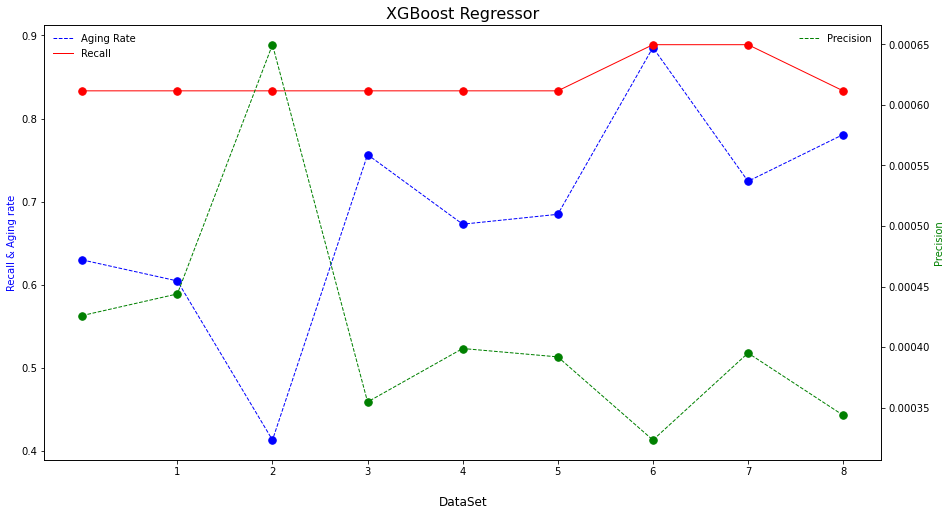

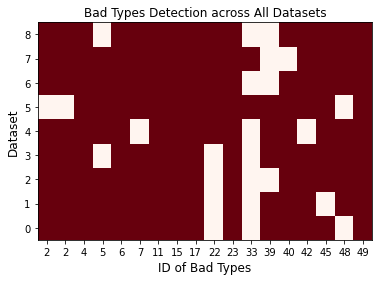


Run Time：207.666667 seconds


In [84]:
start = time.time()

pr_dict, table_set2, bad_set2 = runall_XGBoostR(9, trainset_x, test_x, trainset_y, test_y, thres_target = 'Recall', 
                                                threshold = 0.8)
line_chart(table_set2, title = 'XGBoost Regressor')
bad_plot(bad_set2)

end = time.time()
print("\nRun Time：%f seconds" % (end - start))

,Class_Prob,train_OK,train_NG,Balance Ratio,TP,FP,FN,TN,Recall,Precision,Aging Rate,Efficiency,Score
dataset 0,-0.005715,73116.0,4022.0,18.179015,15.0,35194.0,3.0,20691.0,0.833333,0.000426,0.629823,1.323123,0.702427
dataset 1,-0.007820,73116.0,36556.0,2.000109,15.0,33778.0,3.0,22107.0,0.833333,0.000444,0.604493,1.378565,0.722081
dataset 2,0.000917,73116.0,38569.0,1.895719,15.0,23072.0,3.0,32813.0,0.833333,0.000650,0.412983,2.017838,0.920451
dataset 3,-0.017746,73116.0,38569.0,1.895719,15.0,42277.0,3.0,13608.0,0.833333,0.000355,0.756525,1.101528,0.618887
dataset 4,-0.012242,73116.0,36558.0,2.000000,15.0,37597.0,3.0,18288.0,0.833333,0.000399,0.672808,1.238590,0.671538
dataset 5,-0.000158,20110.0,10051.0,2.000796,15.0,38262.0,3.0,17623.0,0.833333,0.000392,0.684704,1.217071,0.663489
dataset 6,-0.000341,20110.0,12066.0,1.666667,16.0,49486.0,2.0,6399.0,0.888889,0.000323,0.885498,1.003829,0.617831
dataset 7,0.018910,20110.0,12066.0,1.666667,16.0,40484.0,2.0,15401.0,0.888889,0.000395,0.724469,1.226952,0.711675
dataset 8,0.000536,20110.0,10055.0,2.000000,15.0,43631.0,3.0,12254.0,0.833333,0.000344,0.780745,1.067356,0.605226


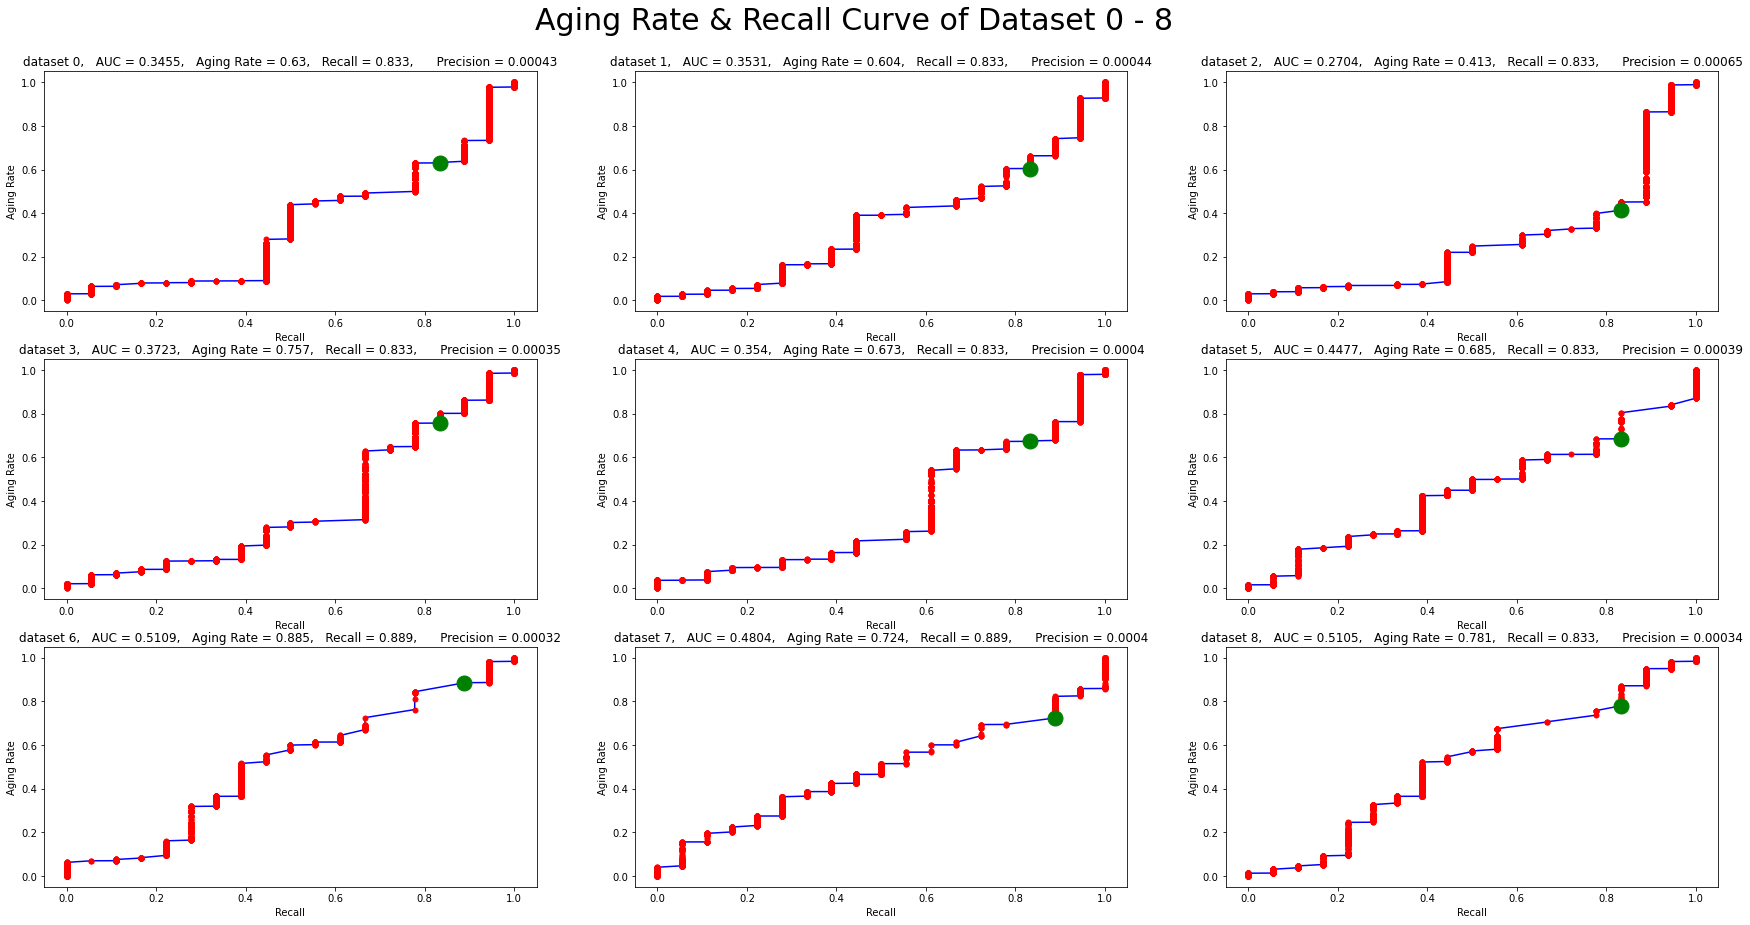

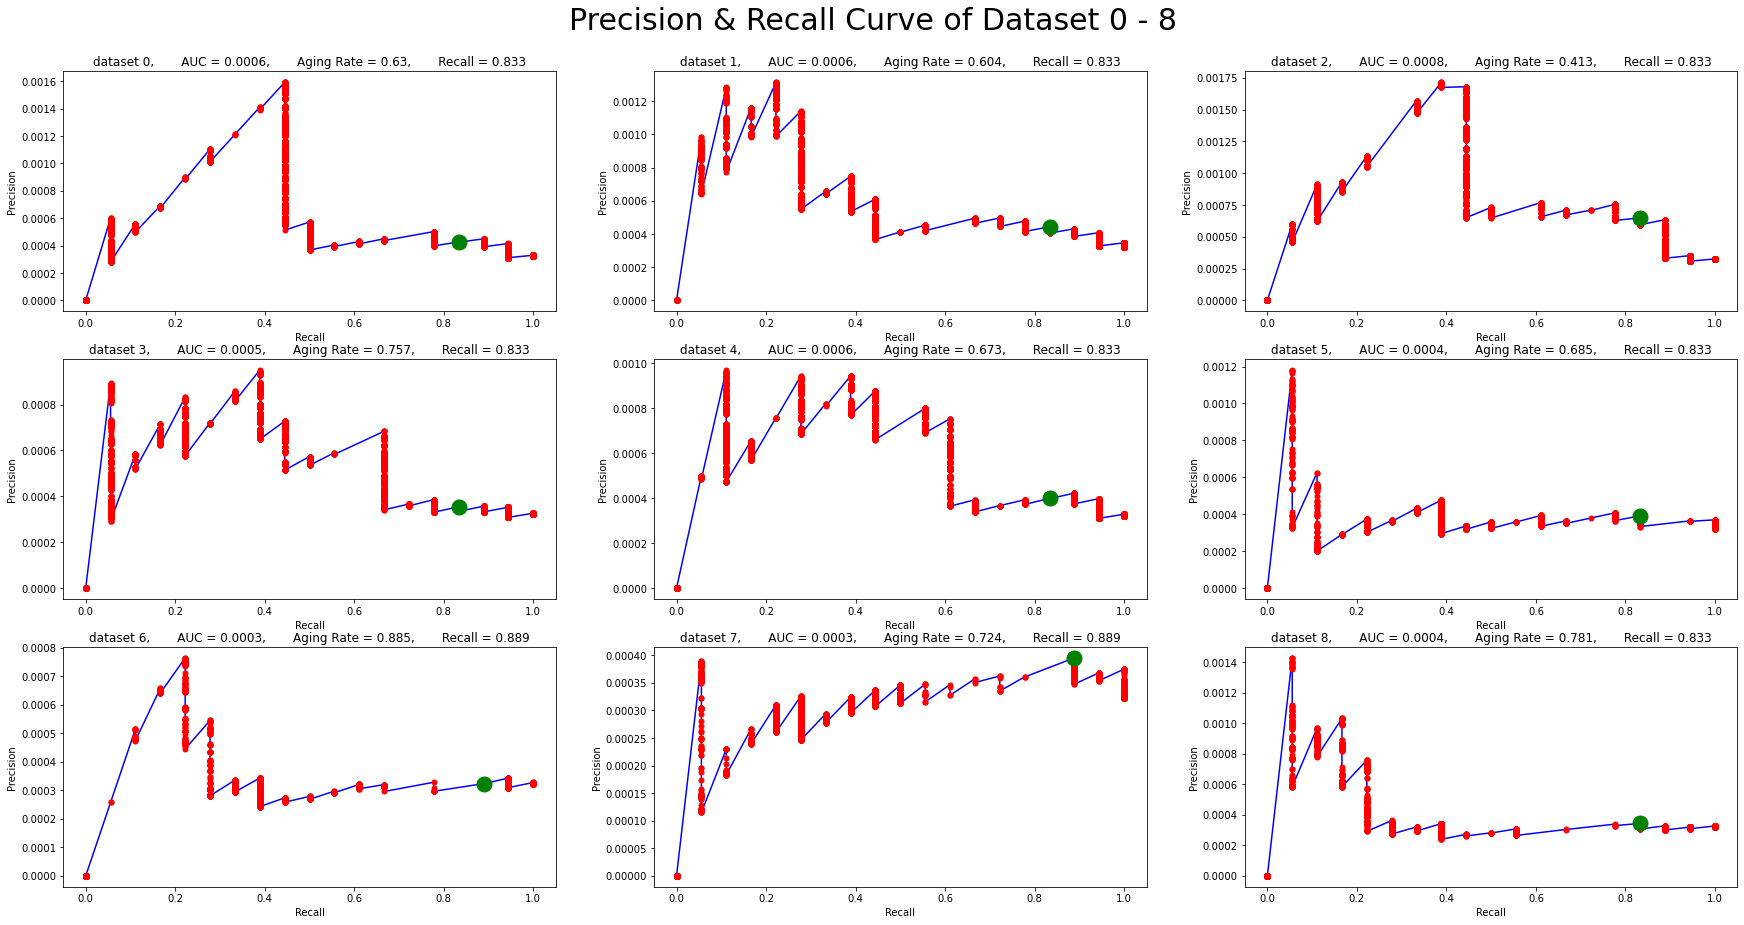

In [83]:
multiple_curve(3, 3, pr_dict, table_set2, target = 'Aging Rate')
multiple_curve(3, 3, pr_dict, table_set2, target = 'Precision')
table_set2